In [46]:
from gym import Env
from gym.spaces import Discrete, Box

import numpy as np
import random
import imp

import pyglet
from pyglet import image

import platform

In [47]:
class ArmEnv(Env):
    viewer = None
    dt = .1    # refresh rate
    
    action_bound = [-1, 1]
    goal = {'x': 100., 'y': 100., 'l': 40}
    state_dim = 9
    action_dim = 2
    dampingK = 0.5
    goal_pos_radius = 200.

    def __init__(self):
        
        #define arm info struct with 2 arms {left, right}
        self.arm_info = np.zeros(2, dtype=[('l', np.float32), ('r', np.float32)])
        self.arm_info['l'] = 100        # 2 arms length
        self.arm_info['r'] = np.pi/6    # 2 angles information
        
        
        #left, Right Arm Movement
        self.action_space = Discrete(2)
        
        #towards produce reward - allows to have a continuous value across a whole range of spaces
        self.observation_space = Box(low=0, high=100, shape=(9,))
        #Box(low=np.array([0]), high=np.array([100]), shape=(9,))
         
        #initialize goal that will help determine reward
        self.on_goal = 0
        
        self.prev_finger_pos = np.array([0, 0])

    def step(self, action):
        
        #initialize simulation to be "not done" => false
        done = False
        
        #apply action
        action = np.clip(action, *self.action_bound)
        self.arm_info['r'] += action * self.dt
        self.arm_info['r'] %= np.pi * 2  # normalize

        (a1l, a2l) = self.arm_info['l']  # radius, arm length
        (a1r, a2r) = self.arm_info['r']  # radian, angle
        a1xy   = np.array([200., 200.])  # a1 start (x0, y0)
        a1xy_  = np.array([np.cos(a1r), np.sin(a1r)]) * a1l + a1xy               # a1 end and a2 start (x1, y1)
        finger = np.array([np.cos(a1r + a2r), np.sin(a1r + a2r)]) * a2l + a1xy_  # a2 end (x2, y2)
        
        # normalize features
        dist1 = [(self.goal['x'] - a1xy_[0]) / 400, (self.goal['y'] - a1xy_[1]) / 400]
        dist2 = [(self.goal['x'] - finger[0]) / 400, (self.goal['y'] - finger[1]) / 400]
        
        #reward
        r = -np.sqrt(dist2[0]**2+dist2[1]**2)

        #done and calculate reward
        if self.goal['x'] - self.goal['l']/2 < finger[0] < self.goal['x'] + self.goal['l']/2:
            if self.goal['y'] - self.goal['l']/2 < finger[1] < self.goal['y'] + self.goal['l']/2:
                r += 1. #- dist/self.goal['l']
                self.on_goal += 1
                if self.on_goal > 50:
                    done = True
        else:
            self.on_goal = 0

        self.prev_finger_pos = finger
    
        #set placeholder for info
        info = {}
        
        # state
        s = np.concatenate((a1xy_/200, finger/200, dist1 + dist2, [1. if self.on_goal else 0.]))
    
        # state, rewards, complete
        return s, r, done, info

    
    def render(self, follow_mouse=True):
        if self.viewer is None:
            self.viewer = Viewer(self.arm_info, self.goal, follow_mouse=follow_mouse)
        self.viewer.render()
  
    
    def reset(self):        
        self.goal['x'] = np.random.rand()*400.
        self.goal['y'] = np.random.rand()*400.
        self.arm_info['r'] = 2 * np.pi * np.random.rand(2)
        self.on_goal = 0
        (a1l, a2l) = self.arm_info['l']  # radius, arm length
        (a1r, a2r) = self.arm_info['r']  # radian, angle
        a1xy = np.array([200., 200.])  # a1 start (x0, y0)
        a1xy_ = np.array([np.cos(a1r), np.sin(a1r)]) * a1l + a1xy  # a1 end and a2 start (x1, y1)
        finger = np.array([np.cos(a1r + a2r), np.sin(a1r + a2r)]) * a2l + a1xy_  # a2 end (x2, y2)
        
        # normalize features
        dist1 = [(self.goal['x'] - a1xy_[0])/400, (self.goal['y'] - a1xy_[1])/400]
        dist2 = [(self.goal['x'] - finger[0])/400, (self.goal['y'] - finger[1])/400]
        
        # state
        s = np.concatenate((a1xy_/200, finger/200, dist1 + dist2, [1. if self.on_goal else 0.]))
        
        return s


    def sample_action(self):
        return np.random.rand(2)-0.5    # two radians



In [48]:
class Viewer(pyglet.window.Window):
    bar_thc = 5

    def __init__(self, arm_info, goal, follow_mouse=True):
        # self.glconfig = pyglet.gl.Config(sample_buffers=1, samples=8) # Windows
        # Linux

        vsync=False # To speed up training  
        if platform.system() == "Darwin":
            super(Viewer, self).__init__(width=400, height=400)
        elif platform.system() == "Linux":
            self.glconfig = pyglet.gl.Config()
            super(Viewer, self).__init__(config=self.glconfig, width=400, height=400, resizable=False, caption='AIM', vsync=vsync, style=pyglet.window.Window.WINDOW_STYLE_BORDERLESS)
        elif platform.system() == "Windows":
            self.glconfig = pyglet.gl.Config(sample_buffers=1, samples=8)
            super(Viewer, self).__init__(config=self.glconfig, width=400, height=400, resizable=False, caption='AIM', vsync=vsync, style=pyglet.window.Window.WINDOW_STYLE_BORDERLESS)
        else:
            super(Viewer, self).__init__(width=400, height=400)
          
        pyglet.gl.glClearColor(0, 0, 0, 0)
        self.arm_info = arm_info
        self.goal_info = goal
        self.center_coord = np.array([200, 200])

        self.batch = pyglet.graphics.Batch()    # display whole batch at once
        self.goal = self.batch.add(
            4, pyglet.gl.GL_QUADS, None,    # 4 corners
            ('v2f', [goal['x'] - goal['l'] / 2, goal['y'] - goal['l'] / 2, # location
                     goal['x'] - goal['l'] / 2, goal['y'] + goal['l'] / 2,
                     goal['x'] + goal['l'] / 2, goal['y'] + goal['l'] / 2,
                     goal['x'] + goal['l'] / 2, goal['y'] - goal['l'] / 2]),
            ('c3B', (96, 96, 96) * 4))    # color

        self.arm1 = self.batch.add(
            4, pyglet.gl.GL_QUADS, None,
            ('v2f', [250, 250,               # location
                     250, 300,
                     260, 300,
                     260, 250]),
            ('c3B', (255, 215, 0) * 4,),     # color
        )
        
        self.arm2 = self.batch.add(
            4, pyglet.gl.GL_QUADS, None,
            ('v2f', [100, 150,               # location
                     100, 160,
                     200, 160,
                     200, 150]),
            ('c3B', (255, 215, 0) * 4,))    

        self.follow_mouse = follow_mouse

    def render(self):
        self._update_arm()
        self.switch_to()
        self.dispatch_events()
        self.dispatch_event('on_draw')
        self.flip()

    def on_draw(self):
        self.clear()
        self.batch.draw()

    def _update_arm(self):
        # update goal
        self.goal.vertices = (
            self.goal_info['x'] - self.goal_info['l']/2, self.goal_info['y'] - self.goal_info['l']/2,
            self.goal_info['x'] + self.goal_info['l']/2, self.goal_info['y'] - self.goal_info['l']/2,
            self.goal_info['x'] + self.goal_info['l']/2, self.goal_info['y'] + self.goal_info['l']/2,
            self.goal_info['x'] - self.goal_info['l']/2, self.goal_info['y'] + self.goal_info['l']/2)

        # update arm
        (a1l, a2l) = self.arm_info['l']     # radius, arm length
        (a1r, a2r) = self.arm_info['r']     # radian, angle
        a1xy = self.center_coord            # a1 start (x0, y0)
        a1xy_ = np.array([np.cos(a1r), np.sin(a1r)]) * a1l + a1xy   # a1 end and a2 start (x1, y1)
        a2xy_ = np.array([np.cos(a1r+a2r), np.sin(a1r+a2r)]) * a2l + a1xy_  # a2 end (x2, y2)

        a1tr, a2tr = np.pi / 2 - self.arm_info['r'][0], np.pi / 2 - self.arm_info['r'].sum()
        xy01 = a1xy + np.array([-np.cos(a1tr), np.sin(a1tr)]) * self.bar_thc
        xy02 = a1xy + np.array([np.cos(a1tr), -np.sin(a1tr)]) * self.bar_thc
        xy11 = a1xy_ + np.array([np.cos(a1tr), -np.sin(a1tr)]) * self.bar_thc
        xy12 = a1xy_ + np.array([-np.cos(a1tr), np.sin(a1tr)]) * self.bar_thc

        xy11_ = a1xy_ + np.array([np.cos(a2tr), -np.sin(a2tr)]) * self.bar_thc
        xy12_ = a1xy_ + np.array([-np.cos(a2tr), np.sin(a2tr)]) * self.bar_thc
        xy21  = a2xy_ + np.array([-np.cos(a2tr), np.sin(a2tr)]) * self.bar_thc
        xy22  = a2xy_ + np.array([np.cos(a2tr), -np.sin(a2tr)]) * self.bar_thc

        self.arm1.vertices = np.concatenate((xy01, xy02, xy11, xy12))
        self.arm2.vertices = np.concatenate((xy11_, xy12_, xy21, xy22))

    # convert the mouse coordinate to goal's coordinate
    def on_mouse_motion(self, x, y, dx, dy):
        if self.follow_mouse:
            self.goal_info['x'] = x
            self.goal_info['y'] = y


In [49]:
env = ArmEnv()

In [50]:
env.action_space.sample()

0

In [51]:
env.observation_space.sample()

array([65.62343  , 89.595955 , 61.091343 , 65.34555  , 80.542496 ,
       26.043304 , 85.375656 ,  4.2873864, 67.914246 ], dtype=float32)

In [52]:
#episodes = 5
#for episode in range (1, episodes):
#    state = env.reset()
#    done  = False
#    score = 0
    
#    while not done:
#        #env.render()
#        action = env.sample_action()
#        n_state, reward, done, info = env.step(action)
#        score+=reward
#    print('Episode:{}, Score:{}, Reward:{}, Done:{} '.format(episode, score, reward, done))

In [53]:
!python -m pip show tensorflow
#!pip show pyproj

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\programdata\anaconda3\envs\aim_sandbox\lib\site-packages
Requires: tensorflow-intel
Required-by: keras-rl2


In [54]:
import os

import numpy as np
import tensorflow 
print("Import tensorflow done")

from tensorflow import keras
from keras.models  import Sequential
from keras.layers  import Dense, Flatten
from keras.optimizers import Adam

# Disable GPU computation
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Import tensorflow done


In [55]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

print("Import keras rl done")

Import keras rl done


In [56]:
import matplotlib.pyplot as plt

print("Import matplotlib done")

Import matplotlib done


In [57]:
states = env.observation_space.shape
actions = env.action_space.n
print(states)
print(actions)



(9,)
2


In [58]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, *states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear')) # softmax, activation='linear', activation=tf.nn.sigmoid
    return model

    #model = Sequential()
    #model.add(Dense(24, activation='relu', input_shape = states))
    #model.add(Dense(24, activation='relu'))
    #model.add(Dense(actions, activation='linear'))
    #return model

In [59]:
#del model

In [60]:
model = build_model(states, actions)

In [61]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 9)                 0         
                                                                 
 dense_6 (Dense)             (None, 24)                240       
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dense_8 (Dense)             (None, 2)                 50        
                                                                 
Total params: 890
Trainable params: 890
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
# Compile model
from keras.optimizers import SGD

# compile the model
sgd = SGD(learning_rate=0.001, momentum=0.8)
model.compile(optimizer=sgd, loss='binary_crossentropy')

# fit the model
#history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.3)

# plot learning curves
#pyplot.title('Learning Curves')
#pyplot.xlabel('Epoch')
#pyplot.ylabel('Cross Entropy')
#pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='val')
#pyplot.legend()
#pyplot.show()

#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

#The three most common loss functions are:

#‘binary_crossentropy‘ for binary classification
#‘sparse_categorical_crossentropy‘ for multi-class classification
#‘mse‘ (mean squared error) for regression

# compile the model
#model.compile(optimizer='sgd', loss='mse')

#https://www.tensorflow.org/api_docs/python/tf/keras/losses

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions = actions, nb_steps_warmup = 100,target_model_update = 1e-2)
    return dqn

In [64]:
print(model)
print(actions)

2


In [65]:
#descreate == 
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae']) #mae
history = dqn.fit(env, nb_steps = 50000, action_repetition=1, callbacks=None, verbose=1, visualize=False, nb_max_start_steps=0, start_step_policy=None, log_interval=10000, nb_max_episode_steps=300)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -0.3376
42 episodes - episode_reward: -79.315 [-207.251, 48.431] - loss: 1.177 - mae: 4.695 - mean_q: -5.540

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -0.4241
39 episodes - episode_reward: -109.649 [-196.052, 47.334] - loss: 2.220 - mae: 6.343 - mean_q: -7.778

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -0.3140
48 episodes - episode_reward: -65.256 [-188.695, 50.097] - loss: 2.609 - mae: 7.472 - mean_q: -10.010

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -0.3537
42 episodes - episode_reward: -84.100 [-195.893, 48.892] - loss: 2.478 - mae: 7.244 - mean_q: -9.556

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -0.3460


In [66]:
# list all data in history
print(history.history.keys())

print(history.history)

# ppo 
# ddpg

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])
{'episode_reward': [-141.15755536888244, -117.17809924232664, -122.41977283035578, -151.13438355364016, -150.94433910561037, -128.48790962430192, -136.7137236349685, -152.82493509807404, -85.26997648668356, -118.33545716298137, -139.96208933732117, 34.67119226231403, 11.27189338419883, 33.68968692589609, 30.74075974367725, -91.69844967873702, 31.357605497535456, -106.41489530232123, -146.3662473623166, 22.994196470460036, -139.15457922849853, 12.790409793684026, 41.591139896459566, -161.28036538596788, 29.541241236021122, 8.13142702890633, -207.2510345306174, -134.06406010638005, 48.43054228706676, 43.57461747327409, -145.44182378731827, -119.81510256983586, -96.29865742117866, -127.53602984311269, -136.67322769383992, 11.872563184836533, 33.26196272250071, -155.24731483692, -129.26886838434743, -143.70704566788444, -120.40285420213993, -120.10368499578287, -137.888672729738, -172.64462842914284, -101.44988464922366, -117.95

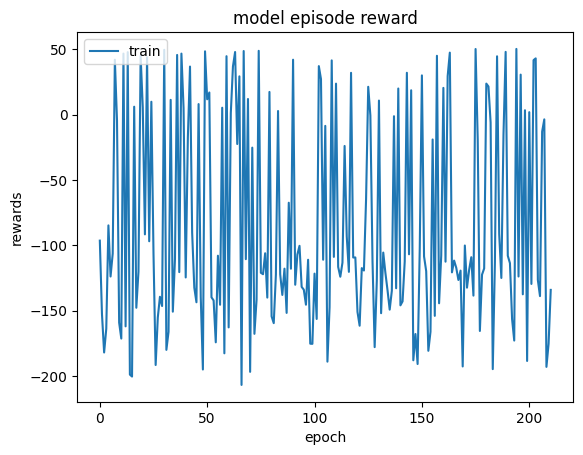

In [45]:
#collects the history returned from training the model and creates two charts

# summarize history for accuracy
# plot of accuracy on the training and validation datasets over training epochs
plt.plot(history.history['episode_reward'])  #accuracy - acc
#plt.plot(history.history['nb_episode_steps'])  #val_accuracy  -  val_acc
plt.title('model episode reward')  #model accuracy
plt.ylabel('rewards')  #accuracy
plt.xlabel('epoch')     #epoch
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
# plot of loss on the training and validation datasets over training epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#score = dqn.test(env, nb_episodes=2, visualize=False)
#print(np.mean(scores_history['episode_reward']))

In [ ]:
# Fit the model
#history = model.fit(X, Y, validation_split=0.33, epochs=4, batch_size=10, verbose=0)

In [ ]:
#seqModel =model.fit(x_train, y_train,
#          batch_size      = batch_size,
#          epochs          = num_epochs,
#          validation_data = (x_test, y_test),
#          shuffle         = True,
#          verbose=0, callbacks=[TQDMNotebookCallback()]) #for visualization

In [ ]:
#from keras.callbacks import History 
#history = History()

In [ ]:
# from keras.callbacks import History 
# history = History()

# list all data in history
# print(history.history.keys())

# print the history of validation loss
# print(history.history['val_loss'])

# 150
#history = model.fit(X, Y, validation_split=0.33, nb_epoch=4, batch_size=10, verbose=0)

In [ ]:
# Visualize training history

#--------------------------------------------------
#  ALREADY IMPORTED EARLIER
#--------------------------------------------------
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#import numpy as np


#import matplotlib.pyplot as plt

# load pima indians dataset
#dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")

# split into input (X) and output (Y) variables
# ACTIONS  ......X = dataset[:,0:8]
# STATES   ......Y = dataset[:,8]

# create model
#model = Sequential()
#model.add(Dense(12, input_dim=8, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

# Compile model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)

# list all data in history
# print(history.history.keys())

#collects the history returned from training the model and creates two charts

# summarize history for accuracy
# plot of accuracy on the training and validation datasets over training epochs
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# summarize history for loss
# plot of loss on the training and validation datasets over training epochs
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()